### Исходные параметры дрона

Технические характеристики:
  - время работы аккумулятора: 25 минут
  - максимальная скорость $XY$: $10 \frac{\text{м}}{\text{c}}$
  - максимальная скорость $Z$: $2 \frac{\text{м}}{\text{c}}$
  - расход жидкости:  $50 \frac{\text{л}}{\text{ч}}$
  - объем бака: $10$ л
  - след рассеивания удобрения: $+1$м от крайней форсунки
  - длина штанги с форсунками: $2$ м
  - время снаряжения коптера (аккумулятор + долив удобрения): $3$ минуты
  - допустимая дистанция между дронами: $3$ м (точность GPS $1$ м)
  - скорость углового поворота: $\frac{\pi}{4} \frac{\text{рад}}{\text{с}}$
  - максимальное развиваемое ускорение: $1 \frac{\text{м}}{\text{с}^2}$
  
Веса ресурсов:
  - аккум : $35%$
  - удобр : $15%$
  - время : $50%$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry as shg

In [2]:
#Coordinates from KML file
x1 = [45.91043204152349,50.50752024855144]
x2 = [45.90929808523507,50.50737081218062]
x3 = [45.90721698424876,50.50676072184594]
x4 = [45.90506986198657,50.5057890410317]
x5 = [45.90767218680866,50.50375778662693]
x6 = [45.91184648100185,50.50651414134762]
x7 = [45.91043204152349,50.50752024855144]

# Изобразим наше поле, представляющее собой выпуклый шестиугольник

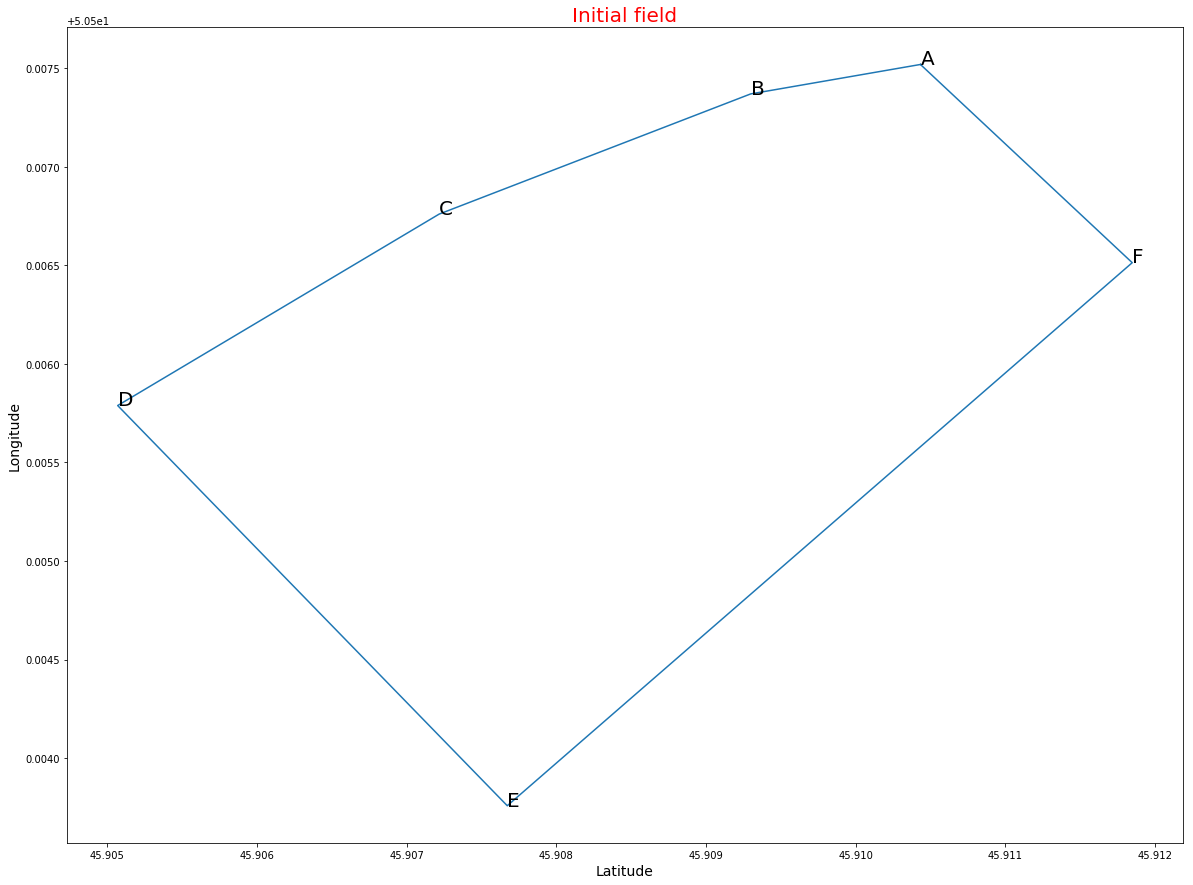

In [3]:
field = shg.Polygon([x1, x2, x3, x4, x5, x6, x7])

fig = plt.figure(figsize=(20, 15))

plt.plot(*field.exterior.xy)
plt.annotate("A", (x1[0], x1[1]), fontsize=20)
plt.annotate("B", (x2[0], x2[1]), fontsize=20)
plt.annotate("C", (x3[0], x3[1]), fontsize=20)
plt.annotate("D", (x4[0], x4[1]), fontsize=20)
plt.annotate("E", (x5[0], x5[1]), fontsize=20)
plt.annotate("F", (x6[0], x6[1]), fontsize=20)

plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Longitude", fontsize=14)

plt.title("Initial field", color='red', fontsize=20)

plt.show()

### Основная идея - осуществить полёт дронов вдоль наиболее протяжённого участка поля (параллельно границе поля $EF$).

Заряда батарейки хватает на $25$ минут, в то время как ёмкости с поливательной смесью - на $\frac{10}{50}\cdot60=12$ минут. Следовательно, для наиболее быстрого полива стоит максимально эффективно расходовать именно поливательную жидкость. 

Ширина поливательной полосы коптера (считаем, что он поднялся на требуемую высоту) - $6$ метров. Однако нужно учесть, что есть погрешность GPC величиной $1$ метр. На основании этого, было предложено 2 модели.

1. Считаем, что эффективная ширина полива дрона - 5 метров. В таком случае нужно разбивать границу $DE$ на 58 частей и от точек разбива строить прямые, параллельные $EF$.
2. Считаем, что эффективная ширина полива дрона - 4 метров. В таком случае нужно разбивать границу $DE$ на 72 части и от точек разбива строить прямые, параллельные $EF$.

Две модели связаны с тем, что у GPC есть погрешность, ввиду которой дрон будет испытывать "колебания" в траектории. Исходим из предположения, что эта погрешность имеет симметричное распределение и, в идеале, гауссовое или степенное (большее отклонение менее вероятно). Посколько было также поставлено условие, что поле должно быть покрыто на 100%, то в связи с этим фактом была выбрана работа по второй модели, с меньшей эффективной шириной полива.

В обоих моделях нужно будет делать посадки дронов, посколько оценочное время облёта, полученное с помощью online-программы ardupilot, показывает $\approx40$ минут и $\approx50$ минут в 1-ой и 2-ой моделях соответственно.

### Опишем схему облёта.

Дроны будут стартовать за $\approx50$ метров до границы $DF$. Это сделано для того, чтобы к тому моменту, когда коптеры окажутся на границе поля $DF$, они набрали высоту ($>2$ м) и скорость ($10 \frac{\text{м}}{\text{с}}$). В момент разгона форсунки будут закрыта, а при достижении границы $DF$ - откроются. Идея - проводить полив поля при максимальное скорости дронов $10 \frac{\text{м}}{\text{с}}$. 

При достижении противоположного конца поля (границ $FA$, $AB$, $BC$, $CD$), форсунки закрываются, а дрон начинает разворачиваться, "перестраиваясь" на "соседнюю полосу". При этом, к моменту перестройки (когда коптер снова вернётся на границу с полем), скорость дрона должна быть близка к максимальной, то есть к $10 \frac{\text{м}}{\text{с}}$. Таким образом будет экономиться поливательная смесь.

Перед началом работы с многоугольником, его для удобства нужно перевести в ортогональную систему координат. Сделано это будет с помощью $\textbf{Transformer}$ в $\textsf{Python}$

In [12]:
from pyproj import Transformer
name_kml = "epsg:4326"      # names of CRS used
name_ortog = "epsg:20009"   # names of ortogonal CRS

transformer_from_kml_to_ortog = Transformer.from_crs(name_kml, name_ortog)
transformer_from_ortog_to_kml = Transformer.from_crs(name_ortog, name_kml)

### Функция для возвращения списка координат долгота/широта/высота из формата полётного задания ArduPilot

In [5]:
def lat_lon_alt_list(filename, skip_first=3, skip_last=2):
    with open(filename) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    
    lat_lon_alt = []

    #Skip first 'skip_first' and last 'skip_last' lines
    for i in range(skip_first, len(content) - skip_last):
        line = content[i].split('\t')
        lat_lon_alt.append([line[9], line[8], line[10]])
    return lat_lon_alt

In [6]:
#Example of output
lat_lon_alt_list('./test.waypoints')[:5]

[['45.91184650', '50.50651410', '2.000000'],
 ['45.91043200', '50.50752020', '2.000000'],
 ['45.90929810', '50.50737080', '2.000000'],
 ['45.90721700', '50.50676070', '2.000000'],
 ['45.90506990', '50.50578900', '2.000000']]

### Функция для записи в формате полётного задания

In [7]:
def control_point(Number, Type, Lat, Lon, Alt, Radius, POIPitch):
    def control_point_full(Number, Type, Lat, Lon, Alt, Radius, WaitTime, MaxHSpeed, MaxVSpeed, 
                  POILat, POILon, POIAltitude, POIHeading, POIPitch, POIRoll, Flg1, Photo, PanoSectors, Delta):
        point = "["
        point += str(Number) + "]"+"\n"
        point += "Type="+str(Type) + "\n"
        point += "Lat="+str(Lat) + "\n"
        point += "Lon="+str(Lon) + "\n"
        point += "Alt="+str(Alt) + "\n"
        point += "Radius="+str(Radius) + "\n"
        point += "WaitTime="+str(WaitTime) + "\n"
        point += "MaxHSpeed="+str(MaxHSpeed) + "\n"
        point += "MaxVSpeed="+str(MaxVSpeed) + "\n"
        point += "POILat="+str(POILat) + "\n"
        point += "POILon="+str(POILon) + "\n"
        point += "POIAltitude="+str(POIAltitude) + "\n"
        point += "POIHeading="+str(POIHeading) + "\n"
        point += "POIPitch="+str(POIPitch) + "\n"
        point += "POIRoll="+str(POIRoll) + "\n"
        point += "Flg1="+str(Flg1) + "\n"
        point += "Photo="+str(Photo) + "\n"
        point += "PanoSectors="+str(PanoSectors) + "\n"
        point += "Delta="+str(Delta) + "\n"
        return point
    point = control_point_full(Number=Number, 
              Type=Type, 
              Lat=Lat,
              Lon=Lon, 
              Alt=Alt, 
              Radius=Radius, 
              WaitTime=0, 
              MaxHSpeed=2.0, 
              MaxVSpeed=6.0, 
              POILat=0, 
              POILon=0, 
              POIAltitude=0, 
              POIHeading=0, 
              POIPitch=POIPitch, 
              POIRoll=0, 
              Flg1=160, 
              Photo=0, 
              PanoSectors=0, 
              Delta=0)
    return point

In [8]:
#Example of output
print(control_point(0, "NAVI_POINT_TAKEOFF", 55.65165099, 37.536942, 6.0, 2.0, -90.0))

[0]
Type=NAVI_POINT_TAKEOFF
Lat=55.65165099
Lon=37.536942
Alt=6.0
Radius=2.0
WaitTime=0
MaxHSpeed=2.0
MaxVSpeed=6.0
POILat=0
POILon=0
POIAltitude=0
POIHeading=0
POIPitch=-90.0
POIRoll=0
Flg1=160
Photo=0
PanoSectors=0
Delta=0



### Функция, принимающая набор точек и генерирующая файл полётного задания

In [9]:
def generate_flight_task(points, filename='ai2flow_flight_task.txt'):
    fp = open(filename, 'w')
    for point in points:
        fp.write(point)
        fp.write('\n')
    fp.close()
    print('Task is done')

In [10]:
#Test example
text1 = control_point(0, "NAVI_POINT_TAKEOFF", 55.65165099, 37.536942, 6.0, 2.0, -90.0)
text2 = control_point(1, "NAVI_POINT_TAKEOFF", 55.65165099, 37.536942, 6.0, 2.0, -270.0)
generate_flight_task([text1, text2], filename='example_flight_task')

Task is done


### Непосредственно  сама генерация

In [11]:
#-90 - for closed nozzles
#-270 - for open nozzles
points_for_fligt_task = []

points_from_ardu_pilot = lat_lon_alt_list('./test.waypoints')

def open_or_closed_nozzle(index):
    return "-270.0" if index % 2 == 0 else "-90.0"

for i in range(len(points_from_ardu_pilot)):
    points_for_fligt_task.append(
        control_point(i + 2, 
                      "NAVI_POINT_SIMPLE", 
                      points_from_ardu_pilot[i][0], 
                      points_from_ardu_pilot[i][1], 
                      points_from_ardu_pilot[i][2], 
                      1.0, 
                      open_or_closed_nozzle(i)))

generate_flight_task(points_for_fligt_task)

Task is done
